In [ ]:
import pandas as pd
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import warnings
import joblib
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [ ]:
print("Downloading Dataset...")
path = kagglehub.dataset_download("adilshamim8/global-traffic-accidents-dataset")
file_path = f"{path}/global_traffic_accidents.csv"
df = pd.read_csv(file_path)

print("Dataset Info:")
print(df.info())
print("\nMissing Values:\n", df.isnull().sum())

if df.isnull().sum().sum() > 0:
    df = df.dropna()  # Atau pakai imputer

# Encode
le = LabelEncoder()
for col in ['Weather Condition', 'Road Condition', 'Cause', 'Location']:
    df[col] = le.fit_transform(df[col])

# Tambahkan kolom 'Risk_Level'
df['Risk_Level'] = pd.cut(df['Casualties'], bins=[-1, 2, 5, 10], labels=[0,1,2]).astype(int)

# Ubah Date & Time menjadi fitur numerik
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Time_Hour'] = pd.to_datetime(df['Time'], format='%H:%M').dt.hour

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Accident ID        10000 non-null  object 
 1   Date               10000 non-null  object 
 2   Time               10000 non-null  object 
 3   Location           10000 non-null  object 
 4   Latitude           10000 non-null  float64
 5   Longitude          10000 non-null  float64
 6   Weather Condition  10000 non-null  object 
 7   Road Condition     10000 non-null  object 
 8   Vehicles Involved  10000 non-null  int64  
 9   Casualties         10000 non-null  int64  
 10  Cause              10000 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 859.5+ KB
None

Missing Values:
 Accident ID          0
Date                 0
Time                 0
Location             0
Latitude             0
Longitude            0
Weather Condition    0
Road C

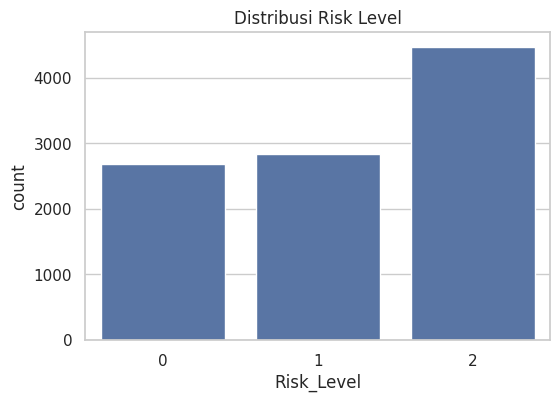

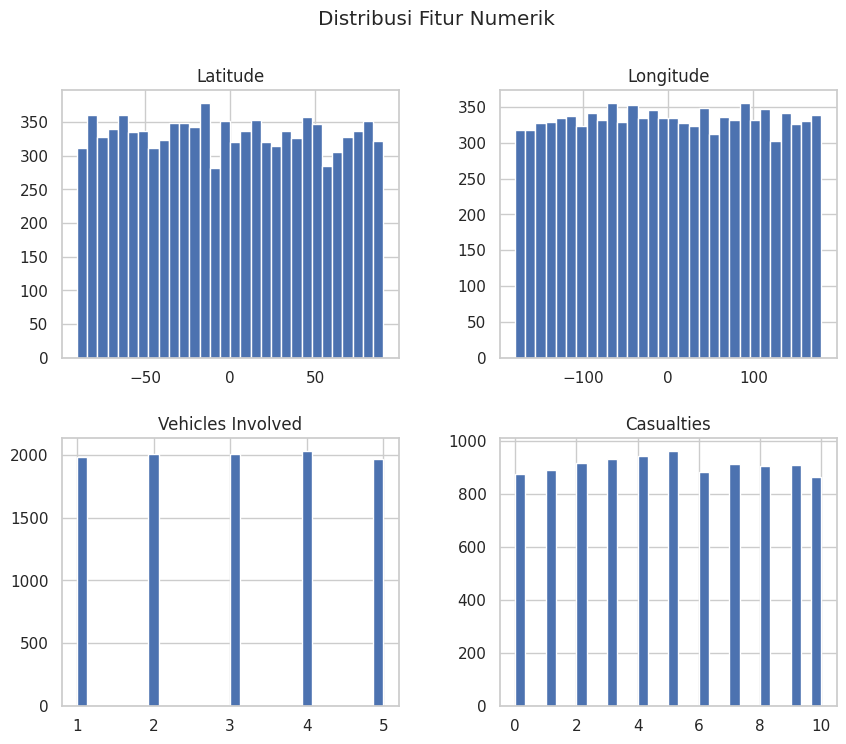

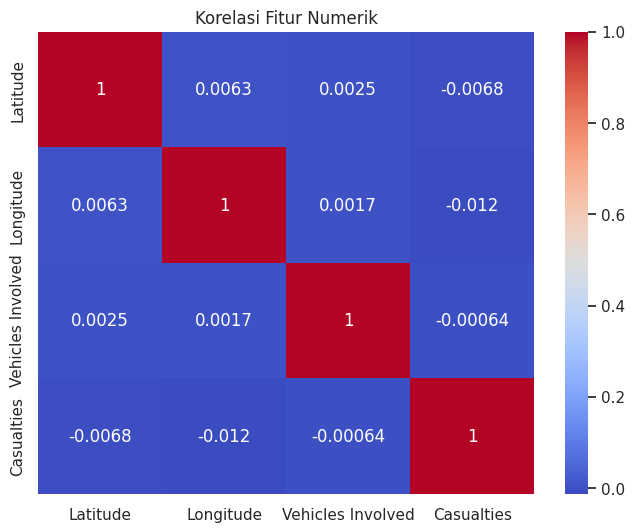

In [ ]:
#Explorasi Data
plt.figure(figsize=(6,4))
sns.countplot(x='Risk_Level', data=df)
plt.title('Distribusi Risk Level')
plt.show()

# Distribusi numerik
num_cols = ['Latitude', 'Longitude', 'Vehicles Involved', 'Casualties']
df[num_cols].hist(figsize=(10,8), bins=30)
plt.suptitle("Distribusi Fitur Numerik")
plt.show()

# Korelasi numerik
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Korelasi Fitur Numerik')
plt.show()

In [ ]:
#Split Data
feature_cols = ['Weather Condition', 'Road Condition', 'Vehicles Involved', 'Latitude', 'Longitude', 'Cause', 'Year', 'Month', 'Day', 'Time_Hour']
X = df[feature_cols]
y = df['Risk_Level']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)


 Training Skema_1
Accuracy: 0.4383, Macro F1: 0.2397
              precision    recall  f1-score   support

           0       0.31      0.03      0.06       805
           1       0.25      0.03      0.05       852
           2       0.45      0.94      0.61      1343

    accuracy                           0.44      3000
   macro avg       0.33      0.33      0.24      3000
weighted avg       0.35      0.44      0.30      3000



<Figure size 500x400 with 0 Axes>

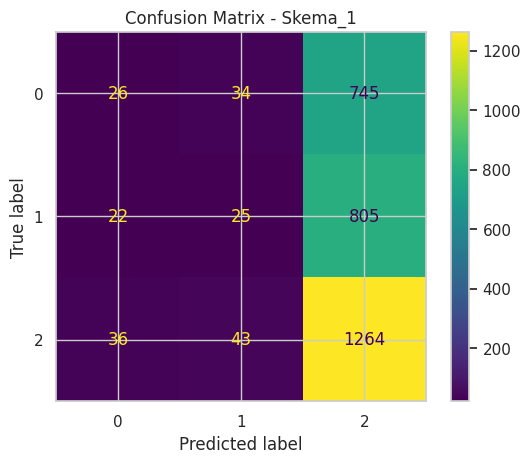

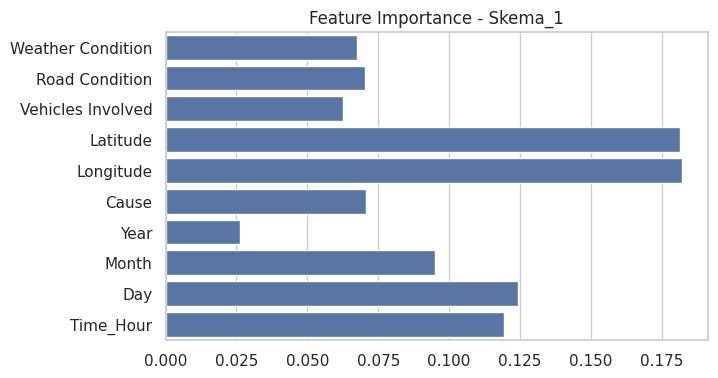


 Training Skema_2
Accuracy: 0.4340, Macro F1: 0.2283
              precision    recall  f1-score   support

           0       0.24      0.02      0.04       805
           1       0.20      0.02      0.04       852
           2       0.45      0.94      0.61      1343

    accuracy                           0.43      3000
   macro avg       0.30      0.33      0.23      3000
weighted avg       0.32      0.43      0.29      3000



<Figure size 500x400 with 0 Axes>

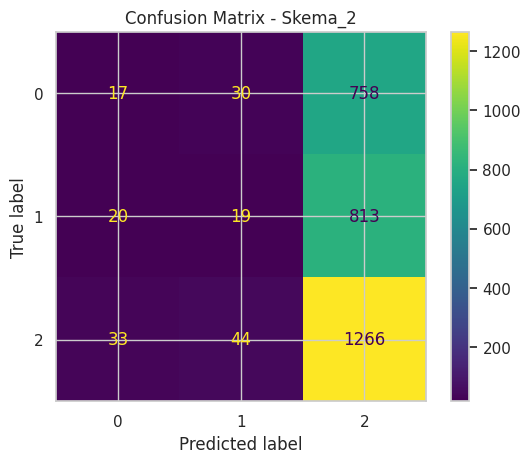

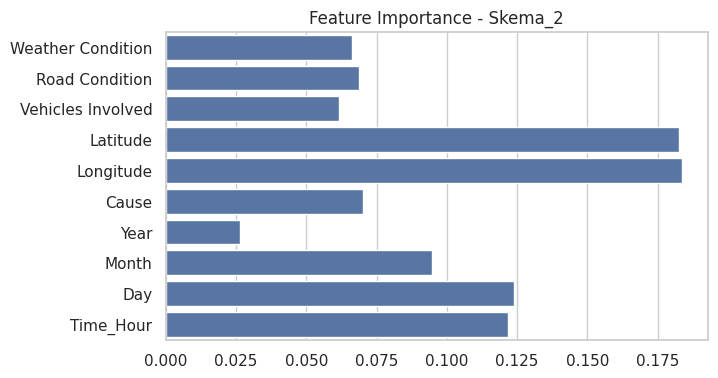


 Training Skema_3
Accuracy: 0.4023, Macro F1: 0.2967
              precision    recall  f1-score   support

           0       0.25      0.10      0.14       805
           1       0.28      0.14      0.19       852
           2       0.45      0.75      0.56      1343

    accuracy                           0.40      3000
   macro avg       0.32      0.33      0.30      3000
weighted avg       0.35      0.40      0.34      3000



<Figure size 500x400 with 0 Axes>

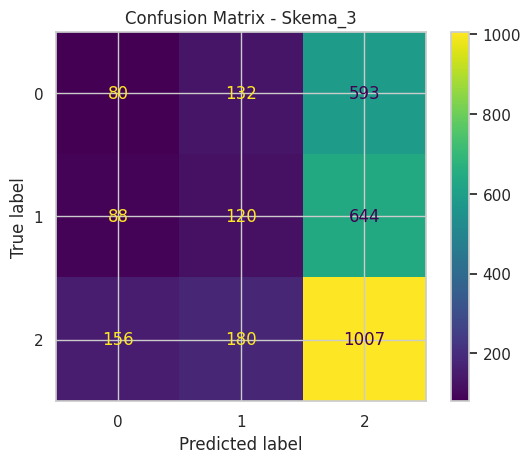

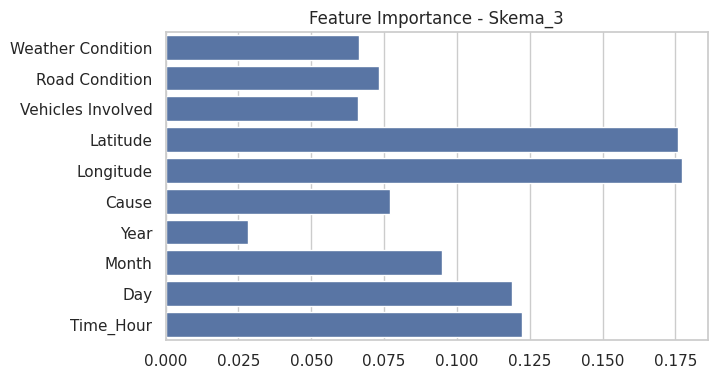

In [ ]:
# Skema 1-3 Modeling Random Forest
models = {
    'Skema_1': RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_split=5, min_samples_leaf=2, random_state=42),
    'Skema_2': RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_split=10, min_samples_leaf=4, max_features='sqrt', random_state=42),
    'Skema_3': RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='log2', bootstrap=False, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n Training {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"Accuracy: {acc:.4f}, Macro F1: {f1:.4f}")
    print(classification_report(y_test, y_pred))
    results[name] = (model, y_pred)

    # Confusion Matrix
    plt.figure(figsize=(5,4))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    # Feature Importance
    importances = model.feature_importances_
    plt.figure(figsize=(7,4))
    sns.barplot(x=importances, y=feature_cols)
    plt.title(f'Feature Importance - {name}')
    plt.show()


Randomized SearchCV for Best Parameters...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

 Best Model Randomized Search - Accuracy: 0.4470, Macro F1: 0.2124
Best Parameters: {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
              precision    recall  f1-score   support

           0       0.30      0.01      0.02       805
           1       0.17      0.00      0.00       852
           2       0.45      0.99      0.62      1343

    accuracy                           0.45      3000
   macro avg       0.31      0.33      0.21      3000
weighted avg       0.33      0.45      0.28      3000



<Figure size 500x400 with 0 Axes>

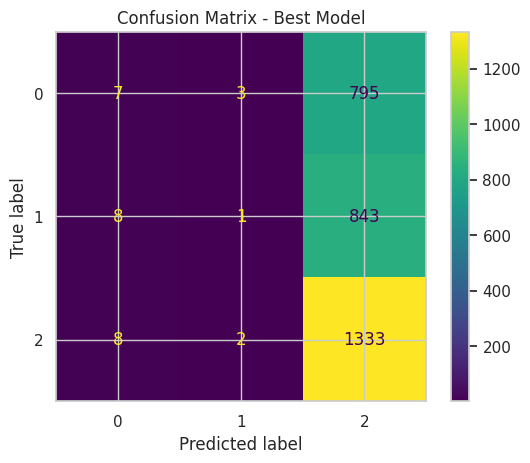

Cross-Validation Accuracy (5-fold): 0.4455 ± 0.0016


In [ ]:
# Advanced Tuning
print("\nRandomized SearchCV for Best Parameters...")
param_grid = {
    'n_estimators': [200, 500, 1000],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

rfc = RandomForestClassifier(random_state=42)
rscv = RandomizedSearchCV(rfc, param_grid, n_iter=20, cv=3, verbose=1, n_jobs=-1)
rscv.fit(X_train, y_train)
best_model = rscv.best_estimator_
y_pred_best = best_model.predict(X_test)
acc_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best, average='macro')
print(f"\n Best Model Randomized Search - Accuracy: {acc_best:.4f}, Macro F1: {f1_best:.4f}")
print("Best Parameters:", rscv.best_params_)
print(classification_report(y_test, y_pred_best))

# Confusion Matrix Best Model
plt.figure(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best)
plt.title('Confusion Matrix - Best Model')
plt.show()

# Cross-validation Score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracy (5-fold): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

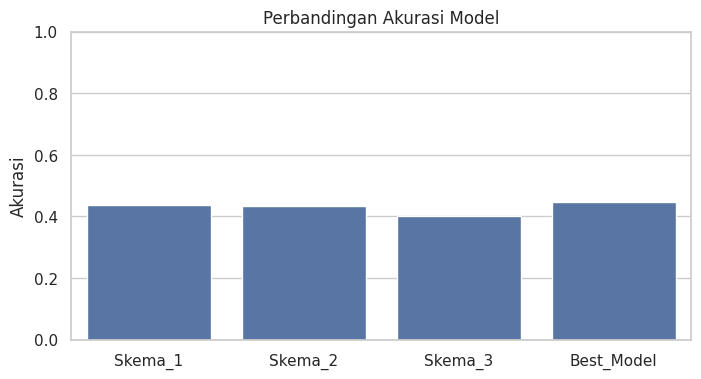

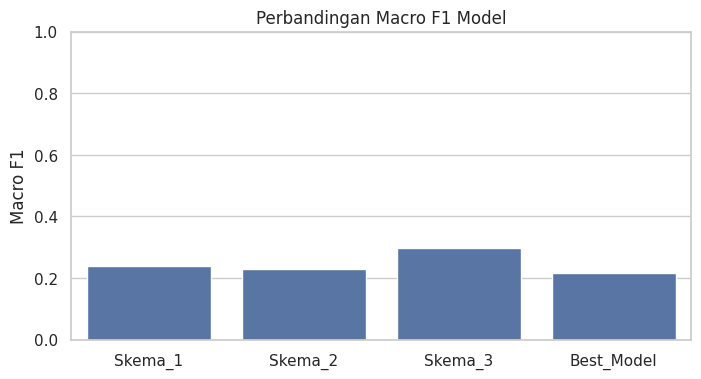

In [ ]:
# Perbandingan Model
model_names = list(results.keys()) + ['Best_Model']
accuracies = [accuracy_score(y_test, results[m][1]) for m in results] + [acc_best]
f1_scores = [f1_score(y_test, results[m][1], average='macro') for m in results] + [f1_best]

plt.figure(figsize=(8,4))
sns.barplot(x=model_names, y=accuracies)
plt.title('Perbandingan Akurasi Model')
plt.ylabel('Akurasi')
plt.ylim(0,1)
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(x=model_names, y=f1_scores)
plt.title('Perbandingan Macro F1 Model')
plt.ylabel('Macro F1')
plt.ylim(0,1)
plt.show()

In [ ]:
# Model Terbaik
joblib.dump(best_model, 'best_random_forest_model.pkl')
print("\n✅ Model terbaik disimpan sebagai 'best_random_forest_model.pkl'.")



✅ Model terbaik disimpan sebagai 'best_random_forest_model.pkl'.
